# Projeto - Maketing Analytics

## <font color='blue'>Segmentação de clientes de food delivery</font>

## Carregando pacotes

In [1]:
# Imports
# Manipulação e visualização de dados
import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as m
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Henrique Macedo Bardella" --iversions

Author: Henrique Macedo Bardella

sklearn   : 0.0
numpy     : 1.21.6
seaborn   : 0.11.2
matplotlib: 3.5.1
pandas    : 1.4.2



## Carregando e compreendendo os datasets

In [3]:
# Dataset
df_food_delivery = pd.read_csv("dados/dataset.csv", encoding = 'utf-8')

In [4]:
# Shape
df_food_delivery.shape

(260645, 7)

In [5]:
df_food_delivery.head()

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


## Análise exploratória

In [6]:
# Verifica o total de valores unicos por coluna
df_food_delivery.nunique()

id_transacao       100000
horario_pedido      76799
localidade              9
nome_item               4
quantidade_item         5
latitude                9
longitude               9
dtype: int64

In [7]:
# Tipos de dados
df_food_delivery.dtypes

id_transacao        object
horario_pedido      object
localidade           int64
nome_item           object
quantidade_item      int64
latitude           float64
longitude          float64
dtype: object

In [8]:
# Resumo das colunas numéricas
df_food_delivery.describe()

,localidade,quantidade_item,latitude,longitude
count,260645.000000,260645.000000,260645.000000,260645.000000
mean,5.134904,2.447010,41.836095,-87.733930
std,2.551846,1.330863,0.144459,0.136369
min,1.000000,1.000000,41.524598,-88.010140
25%,3.000000,1.000000,41.784576,-87.849468
50%,5.000000,2.000000,41.881818,-87.677606
75%,7.000000,4.000000,41.889047,-87.627059
max,9.000000,5.000000,42.049306,-87.607565


### Criando uma tabela que fornecerá o número de vezes cada item foi solicitado em cada pedido

In [9]:
type(df_food_delivery)

pandas.core.frame.DataFrame

In [10]:
# Cria uma tabela pivot com id_transacao, nome_item e quantidade_item
df_pivot = df_food_delivery.pivot_table(index = ['id_transacao'], columns = ['nome_item'], values = 'quantidade_item')

In [11]:
df_pivot

nome_item,bebida,pizza,salada,sobremesa
id_transacao,,,,
0x10000a,NaN,1.0,NaN,1.0
0x100058,NaN,2.0,NaN,2.0
0x1000c8,4.0,4.0,1.0,5.0
0x10014c,NaN,1.0,NaN,1.0
0x1001d8,3.0,3.0,NaN,3.0
...,...,...,...,...
0xffe96,4.0,4.0,NaN,4.0
0xffeed,NaN,1.0,NaN,1.0
0xfff07,1.0,1.0,NaN,1.0


In [12]:
# Substitui valores NA gerados, por 0 e transformados em índice na coluna
df_pivot = df_pivot.fillna(0).reset_index()

In [13]:
type(df_pivot)

pandas.core.frame.DataFrame

In [14]:
df_pivot.dtypes

nome_item
id_transacao     object
bebida          float64
pizza           float64
salada          float64
sobremesa       float64
dtype: object

In [15]:
# Nomes das colunas
df_pivot.columns

Index(['id_transacao', 'bebida', 'pizza', 'salada', 'sobremesa'], dtype='object', name='nome_item')

In [16]:
# Visualiza os dados
df_pivot.head()

nome_item,id_transacao,bebida,pizza,salada,sobremesa
0,0x10000a,0.0,1.0,0.0,1.0
1,0x100058,0.0,2.0,0.0,2.0
2,0x1000c8,4.0,4.0,1.0,5.0
3,0x10014c,0.0,1.0,0.0,1.0
4,0x1001d8,3.0,3.0,0.0,3.0


In [17]:
# Valores únicos
df_pivot.nunique()

nome_item
id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
dtype: int64

In [18]:
# Shape
df_pivot.shape

(100000, 5)

In [19]:
# Describe
df_pivot.describe()

nome_item,bebida,pizza,salada,sobremesa
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.239590,1.857840,0.711370,2.569210
std,1.627886,1.588589,1.086524,1.332084
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,1.000000
50%,0.000000,1.000000,0.000000,2.000000
75%,3.000000,3.000000,1.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [20]:
# não podemos ter valores nulos
df_pivot.isnull().sum()

nome_item
id_transacao    0
bebida          0
pizza           0
salada          0
sobremesa       0
dtype: int64

In [21]:
# Inclui a coluna localidade e para fazer o merge precisamos de uma coluna em comum, nesse caso, id_transacao
df_pivot2 = df_pivot.merge(df_food_delivery[['id_transacao', 'localidade']])

In [22]:
# Visualiza os dados
df_pivot2.head()

,id_transacao,bebida,pizza,salada,sobremesa,localidade
0,0x10000a,0.0,1.0,0.0,1.0,9
1,0x10000a,0.0,1.0,0.0,1.0,9
2,0x100058,0.0,2.0,0.0,2.0,6
3,0x100058,0.0,2.0,0.0,2.0,6
4,0x1000c8,4.0,4.0,1.0,5.0,9


In [23]:
# Shape
df_pivot2.nunique()

id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
localidade           9
dtype: int64

## Extraindo granularidade de tempo

In [24]:
# Visualiza os dados originais
df_food_delivery.head()

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


In [25]:
# Lista para receber o total de pedidos
total_pedidos = []

In [26]:
%%time

print("\nIniciando o agrupamento para o cálculo do total de pedidos. Seja paciente e aguarde...")

# Extraímos cada id e cada grupo do 'group by' por id_transacao
for k, group in df_food_delivery.groupby('id_transacao'):
    
    # Extraímos cada id e cada grupo do group by por horario_pedido
    for m, n in group.groupby('horario_pedido'):
        
        # Extraímos cada item de cada grupo
        id_transacao = k
        horario_pedido = m
        localidade = n['localidade'].values.tolist()[0]
        bebida = 0
        pizza = 0
        sobremesa = 0
        salada = 0
        n = n.reset_index(drop = True)
        
        # E então contabilizamos os itens pedidos
        for i in range(len(n)):
            item = n.loc[i, 'nome_item']
            num = n.loc[i, 'quantidade_item']
            
            if item == 'bebida':
                bebida = bebida + num
            
            elif item == 'pizza':
                pizza = pizza + num
            
            elif item == 'sobremesa':
                sobremesa = sobremesa + num
            
            elif item == 'salada':
                salada = salada + num
        
        output = [id_transacao, horario_pedido, localidade, bebida, pizza, sobremesa, salada]
        total_pedidos.append(output)
        
print("\nAgrupamento concluído!")


Iniciando o agrupamento para o cálculo do total de pedidos. Seja paciente e aguarde...

Agrupamento concluído!
CPU times: total: 58.5 s
Wall time: 58.9 s


In [27]:
# Convertemos a lista para dataframe
df_item_pedidos = pd.DataFrame(total_pedidos)

In [28]:
# Ajustamos os nomes das colunas
df_item_pedidos.columns = ['id_transacao', 'horario_pedido', 'localidade', 'bebida', 'pizza', 'sobremesa', 'salada']

In [29]:
# Shape
df_item_pedidos.shape

(100000, 7)

In [30]:
# Visualiza os dados originais
df_food_delivery.head()

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


### Extraindo Granularidade de Tempo


In [31]:
# Visualiza os dados
df_item_pedidos.head(3)

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1


In [32]:
# Extraimos o mês da coluna horario_pedido e gramamos em uma nova coluna
df_item_pedidos['mes'] = df_item_pedidos['horario_pedido'].apply(lambda x: time.strftime("%m", time.strptime(x, "%Y-%m-%d %H:%M:%S")))

In [33]:
# Visualiza o resultado
df_item_pedidos.head(10)

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada,mes
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0,01
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0,05
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1,01
3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0,02
4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0,06
5,0x1002af,2019-12-28 17:25:00,9,3,3,4,1,12
6,0x10034c,2019-03-12 18:17:00,5,3,4,4,0,03
7,0x100378,2019-10-13 18:44:00,4,4,4,5,1,10
8,0x100391,2019-10-10 18:07:00,5,4,4,4,0,10
9,0x1003a9,2019-06-23 00:39:00,6,0,2,2,0,06


In [34]:
# Incluir a coluna localidade e para fazer o morge precisamos de uma coluna em comum, nesse caso, id_transacao
df_pivot = df_pivot.merge(df_item_pedidos[['id_transacao', 'mes']])

In [35]:
df_pivot.head(10)

,id_transacao,bebida,pizza,salada,sobremesa,mes
0,0x10000a,0.0,1.0,0.0,1.0,01
1,0x100058,0.0,2.0,0.0,2.0,05
2,0x1000c8,4.0,4.0,1.0,5.0,01
3,0x10014c,0.0,1.0,0.0,1.0,02
4,0x1001d8,3.0,3.0,0.0,3.0,06
5,0x1002af,3.0,3.0,1.0,4.0,12
6,0x10034c,3.0,4.0,0.0,4.0,03
7,0x100378,4.0,4.0,1.0,5.0,10
8,0x100391,4.0,4.0,0.0,4.0,10
9,0x1003a9,0.0,2.0,0.0,2.0,06


In [36]:
df_item_pedidos.index

RangeIndex(start=0, stop=100000, step=1)

In [37]:
# fazemos o reset no indice e gravamos o resultado em outro df.
df_item_pedidos_idx = df_item_pedidos.reset_index()

In [38]:
# Resulta em uma coluna ID com um único valore para cada registro
df_item_pedidos_idx.head()

,index,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada,mes
0,0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0,01
1,1,0x100058,2019-05-05 00:08:00,6,0,2,2,0,05
2,2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1,01
3,3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0,02
4,4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0,06


In [39]:
df_item_pedidos

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada,mes
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0,01
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0,05
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1,01
3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0,02
4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0,06
...,...,...,...,...,...,...,...,...
99995,0xffe96,2019-01-05 19:28:00,4,4,4,4,0,01
99996,0xffeed,2019-08-08 00:42:00,2,0,1,1,0,08
99997,0xfff07,2019-05-04 00:48:00,2,1,1,1,0,05
99998,0xfff4d,2019-07-18 00:17:00,3,0,2,2,0,07


# Análise descritiva

### distplot dos atributos usados para segmentação

In [40]:
import warnings
warnings.filterwarnings('ignore')

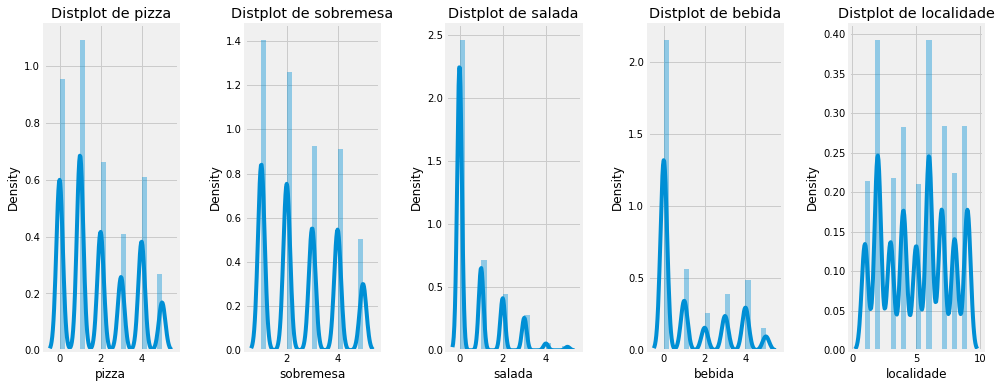

In [41]:
# Plot

# tamanho da figura
plt.figure(1, figsize = (15, 6))

# inicia o contador
n = 0

# Loop pelas colunas
for x in ['pizza', 'sobremesa', 'salada', 'bebida', 'localidade']:
    n += 1
    plt.subplot(1, 5, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot(df_item_pedidos[x], bins = 20)
    plt.title('Distplot de {}'.format(x))
plt.show()   


### Gráfico de Total de Pedidos Por Localidade

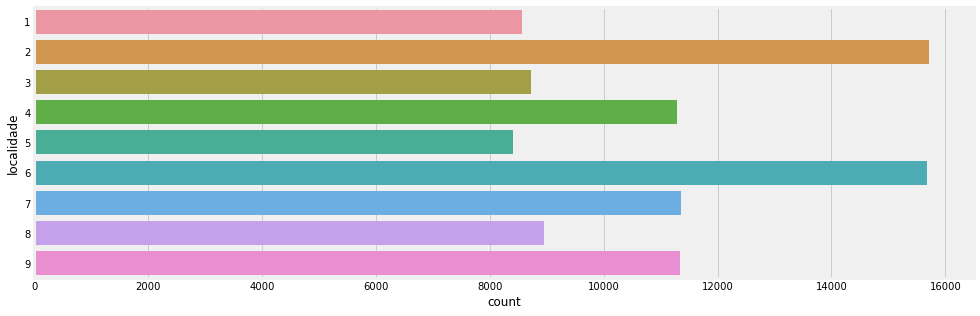

In [42]:
# Plot
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'localidade' , data = df_item_pedidos)
plt.show()

### Regplot dos Atributos Usados Para Segmentação

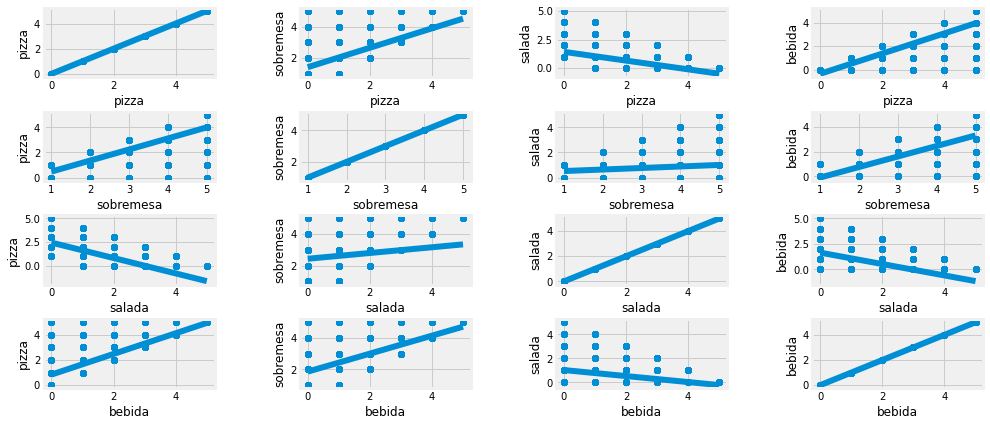

In [43]:
# Relação Entre os Atributos

# Tamanho da figura
plt.figure(1 , figsize = (15 , 7))

# Inicializa o contador
n = 0 

# Loop pelos atributos
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
    for y in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
        n += 1
        plt.subplot(4 , 4 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df_item_pedidos)
        plt.ylabel(y)
plt.show()

### Definindo as Variáveis Para Segmentação

Vamos remover id_transacao, horario_pedido, localidade e mes para nossas primeiras atividades de clusterização.

In [44]:
# Filtrando o dataframe por colunas
df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada']]

,index,bebida,pizza,sobremesa,salada
0,0,0,1,1,0
1,1,0,2,2,0
2,2,4,4,5,1
3,3,0,1,1,0
4,4,3,3,3,0
...,...,...,...,...,...
99995,99995,4,4,4,0
99996,99996,0,1,1,0
99997,99997,1,1,1,0
99998,99998,0,2,2,0


In [45]:
# Vamos gerar um novo dataframe com o slice anterior
df = df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada']]

In [46]:
df.head()

,index,bebida,pizza,sobremesa,salada
0,0,0,1,1,0
1,1,0,2,2,0
2,2,4,4,5,1
3,3,0,1,1,0
4,4,3,3,3,0


## Segmentação 1
- usando 2 variáveis (Pizza e sobremesa)

In [47]:
# Usando duas variáveis
X1 = df[['pizza', 'sobremesa']].iloc[: , :].values

In [48]:
# Lista do WCSS
wcss_X1 = []

Muitas vezes, os dados com os quais você trabalha têm várias dimensões, dificultando a visualização. Como consequência, o número ideal de clusters não é muito óbvio. Felizmente, temos uma maneira de determinar isso matematicamente.

- Representamos graficamente a relação entre o número de clusters e a soma dos quadrados dentro do cluster (Within Cluster Sum of Squares - WCSS) e, em seguida, selecionamos o número de clusters nos quais a mudança no WCSS começa a se estabilizar (Método Elbow).

#### Segmentação 1 - Encontrando o Valor Ideal de Clusters

- Vamos testar diferentes valores de K (valores de cluster) entre 2 e 10.

- Para a inicialização dos clusters, usamos o algoritmo k-means++ que oferece convergência mais rápida para o resultado final.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [49]:
# Loop para testar os valore de K
for n in range(2, 11):
    modelo = (KMeans(n_clusters = n,
                     init = 'k-means++',
                     n_init = 10,
                     max_iter = 300,
                     tol = 0.0001,
                     random_state = 111,
                     algorithm = 'elkan'                   
                        ))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

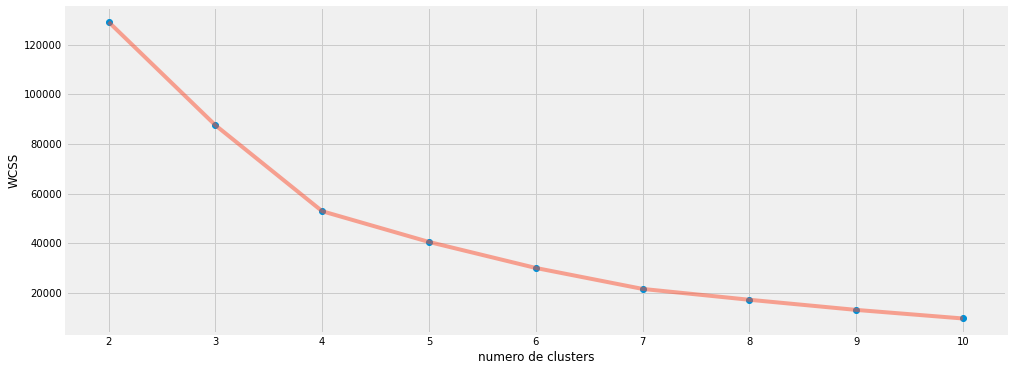

In [50]:
# Plot
plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(2, 11), wcss_X1 , 'o')
plt.plot(np.arange(2, 11), wcss_X1, '-', alpha= 0.5)
plt.xlabel('numero de clusters'), plt.ylabel('WCSS')
plt.show()

Escolhemos o valor ideal de clusters e criamos o modelo final para a Segmentação 1. Observe no gráfico acima que não há certo ou errado. Poderíamos trabalhar com qualquer valor entre 2 e 10 (não faz sentido criar apenas 1 cluster).

O gráfico acima é chamado de Curva de Elbow e normalmente usamos o valor com o menor WCSS. Mas isso deve ser alinhado com as necessidade de negócio. Para esse exemplo, não faria sentido usar 10 clusters. Vamos começar com 2 clusters e avaliar e interpretar os resultados.

Vamos criar o modelo com 4 clusters.

#### Segmentação 1 - Construindo e Treinando o Modelo


In [61]:
# Criação do modelo
modelo_seg1 = KMeans(n_clusters = 2,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 300,
                    tol = 0.0001,
                    random_state = 111,
                    algorithm = 'elkan')

In [62]:
# Treinamento do modelo
modelo_seg1.fit(X1)

KMeans(algorithm='elkan', n_clusters=2, random_state=111)

In [63]:
# Extração dos labels
labels1 = modelo_seg1.labels_
labels1

array([0, 0, 1, ..., 0, 0, 0])

In [65]:
# Extração dos centróides
centroids1 = modelo_seg1.cluster_centers_
centroids1

array([[0.881644  , 1.82183485],
       [3.79958153, 4.05580631]])

#### Segmentação 1 - Visualização e Interpretação dos Segmentos

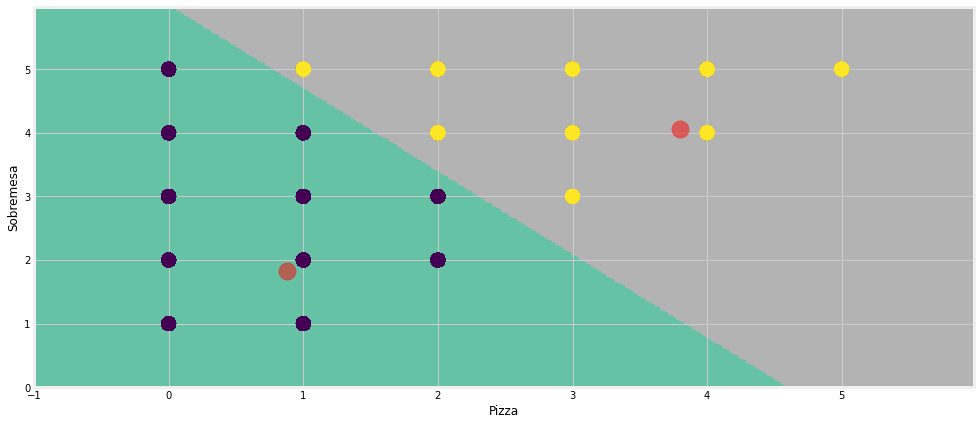

In [66]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = modelo_seg1.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Set2, 
           aspect = 'auto', 
           origin = 'lower')

# Plot dos pontos de dados
plt.scatter( x = 'pizza', y = 'sobremesa', data = df, c = labels1, s = 200 )
plt.scatter(x = centroids1[: , 0], y =  centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Sobremesa')
plt.show()

**Interpretação**: 

- O ponto vermelho é o centróide de cada cluster (segmento).


- No cluster 1 (área em verde) temos os clientes que pediram 0, 1 ou 2 Pizzas. Em todos os casos houve pedido de Sobremesa.


- No cluster 2 (área em cinza) estão clientes que pediram 2, 3, 4 ou 5 Pizzas. Perceba que à medida que o pedido tem maior número de Pizzas, também aumenta o número de Sobremesas.